In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print (itos)
print (vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".": 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print (X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),                 generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),     generator=g) * (5/3)/((n_embd * block_size) ** 0.5)
# b1 = torch.randn(n_hidden,                            generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),              generator=g) * 0.01
b2 = torch.randn(vocab_size,                          generator=g) * 0.0

# Batch Norm Params
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
epsilon = 1e-5

parameters = [C, W1, W2, b2, bngain, bnbias]
print (sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [7]:
max_steps = 200000
batch_size = 32
lossi = []
 
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    # Linear Layer
    hpreact = embcat @ W1 # + b1
    
    # Batch Norm
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True)
    hpreact = ((bngain * (hpreact - bnmeani)) / (bnstdi + epsilon)) + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstdi_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # Non-Linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Log
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())



      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0198
 190000/ 200000: 2.1707


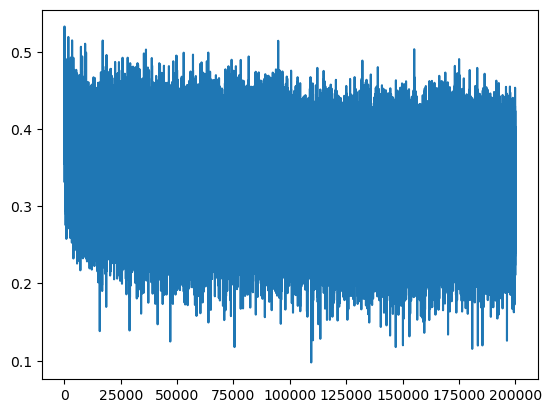

In [8]:
plt.plot(lossi)

In [12]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val':   (Xdev, Ydev),
        'test':   (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    hpreact = ((bngain * (hpreact - bnmean_running)) / (bnstd_running + epsilon)) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print (split, loss.item())


split_loss('val')
split_loss('train')

val 2.314099073410034
train 2.2540571689605713


In [15]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1
        hpreact = ((bngain * (hpreact - bnmean_running)) / (bnstd_running + epsilon)) + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print (''.join(itos[i] for i in out))



carlah.
quinlee.
fregrachette.
skylynn.
jazzuri.
breyah.
jacquin.
kathealceriivia.
jevyn.
zam.
pristen.
juliani.
mattheba.
wrathogiel.
brixtt.
munie.
demet.
zaxia.
gius.
jastin.


In [ ]:
# Pytorch-ifying the code

In [58]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)/fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers trained with a running 'momentum update'
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pas
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = ((1-self.momentum) * self.running_mean) + (self.momentum * xmean)
                self.running_var = ((1-self.momentum) * self.running_var) + (self.momentum * xvar)
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),           generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    #make last layer less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print (sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [59]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []
counter = 0
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # Backward Pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print (f'{i:7d}/{max_steps:7d} loss: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        counter+=1
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])
    if i > 1000:
        print (f'p shape: {p.shape}')
        print (i)
        print (counter)
        break

      0/ 200000 loss: 3.2962
p shape: torch.Size([27])
1001
1002


In [61]:
print (len(ud))
print (len(ud[0]))

1002
13


In [46]:
print (len(parameters))
print (type(parameters))
print ("\n")

print (len(parameters[1]))
print (type(parameters[1]))
print ((parameters[1]).shape)
print ("\n")

print (len(parameters[2]))
print (type(parameters[2]))
print ((parameters[2]).shape)
print ("\n")

print (len(parameters[3]))
print (type(parameters[3]))
print ((parameters[3]).shape)

13
<class 'list'>


30
<class 'torch.Tensor'>
torch.Size([30, 100])


100
<class 'torch.Tensor'>
torch.Size([100])


100
<class 'torch.Tensor'>
torch.Size([100, 100])


layer 1 (      Tanh): mean -0.07, std 0.76, saturated: 22.19%
layer 3 (      Tanh): mean +0.00, std 0.72, saturated: 12.16%
layer 5 (      Tanh): mean -0.00, std 0.75, saturated: 15.00%
layer 7 (      Tanh): mean -0.04, std 0.74, saturated: 13.25%
layer 9 (      Tanh): mean -0.01, std 0.71, saturated: 11.22%


Text(0.5, 1.0, 'activation distribution')

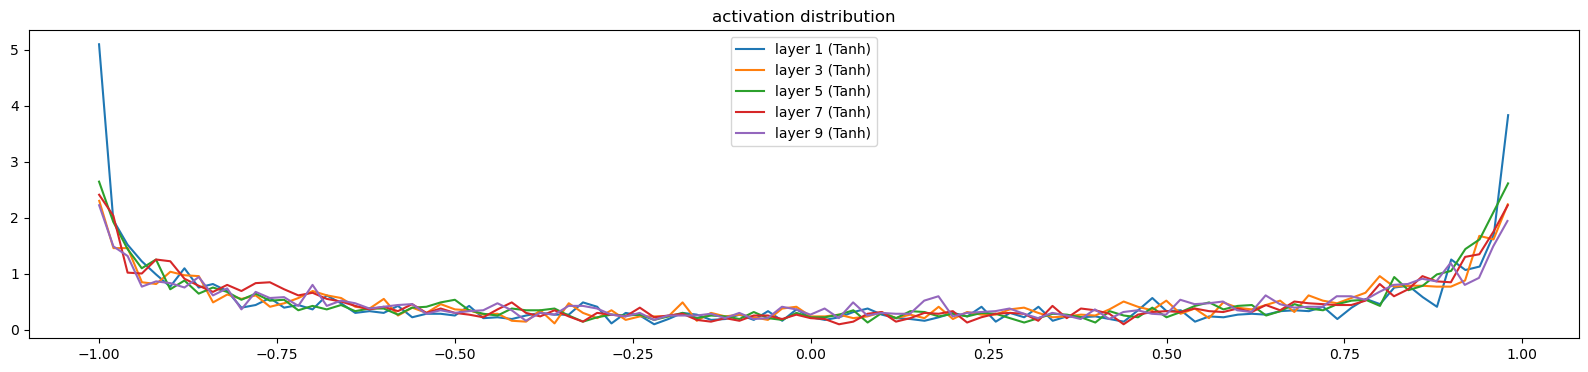

In [47]:
plt.figure(figsize = (20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # excluding the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print ('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("activation distribution")

layer 1 (      Tanh): mean -0.000005, std 3.059083e-03
layer 3 (      Tanh): mean +0.000037, std 3.085331e-03
layer 5 (      Tanh): mean -0.000007, std 2.888204e-03
layer 7 (      Tanh): mean +0.000012, std 2.756315e-03
layer 9 (      Tanh): mean +0.000007, std 2.337389e-03


Text(0.5, 1.0, 'gradient distribution')

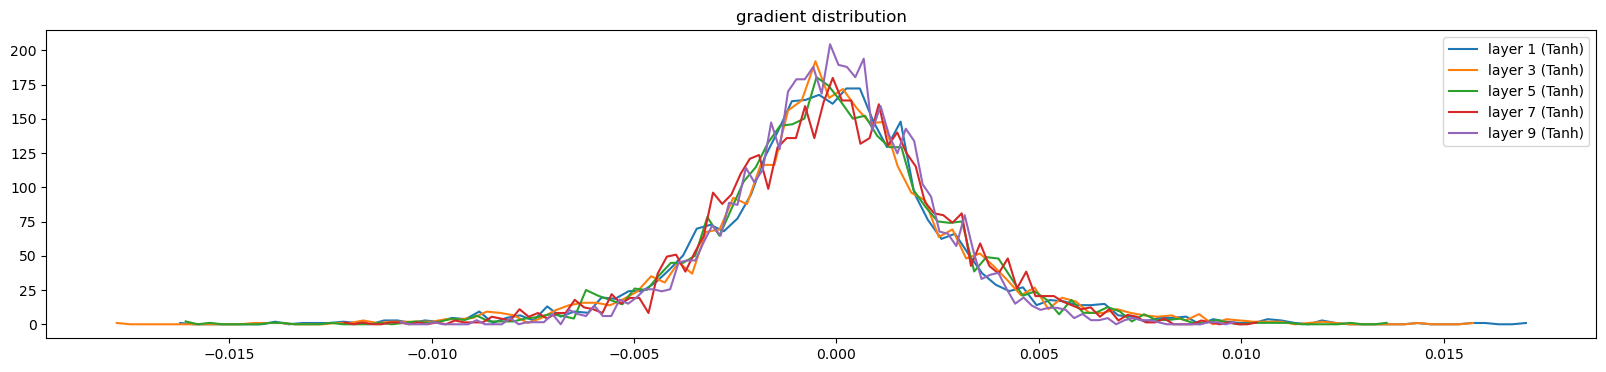

In [48]:
plt.figure(figsize = (20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # excluding the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print ('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("gradient distribution")

weight   (27, 10) | mean +0.000772 | std 9.714618e-03 | grad:data ratio 9.714505e-03
weight  (30, 100) | mean -0.000036 | std 8.734046e-03 | grad:data ratio 2.792835e-02
weight (100, 100) | mean +0.000085 | std 7.424625e-03 | grad:data ratio 4.417370e-02
weight (100, 100) | mean +0.000055 | std 6.242012e-03 | grad:data ratio 3.681916e-02
weight (100, 100) | mean +0.000007 | std 6.161662e-03 | grad:data ratio 3.650614e-02
weight (100, 100) | mean +0.000069 | std 5.221998e-03 | grad:data ratio 3.102274e-02
weight  (100, 27) | mean +0.000000 | std 2.281147e-02 | grad:data ratio 3.229574e-01


Text(0.5, 1.0, 'weights gradient distribution')

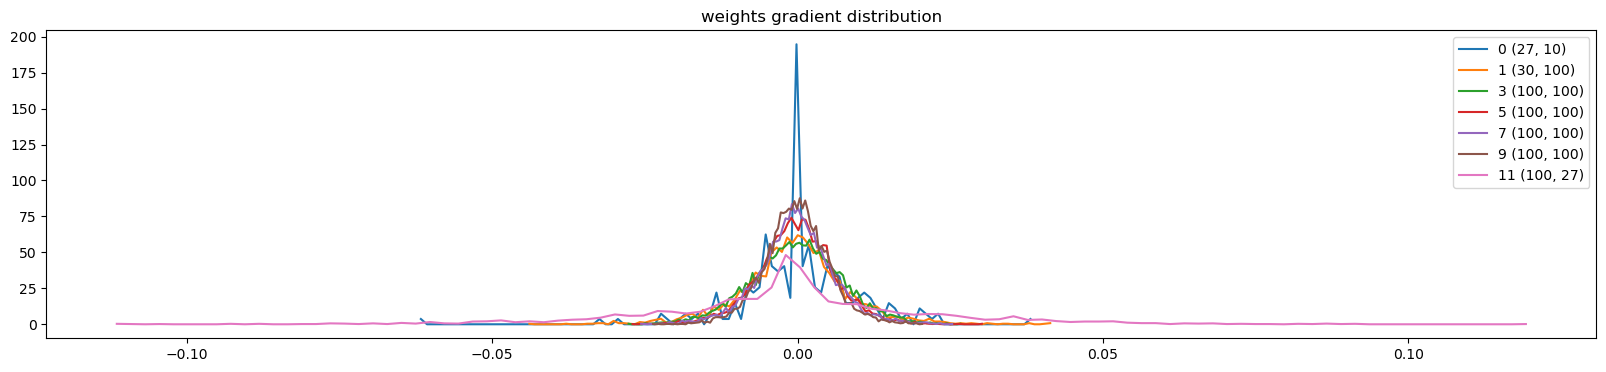

In [49]:
plt.figure(figsize = (20,4))
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print ('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))                                                                   
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title("weights gradient distribution")

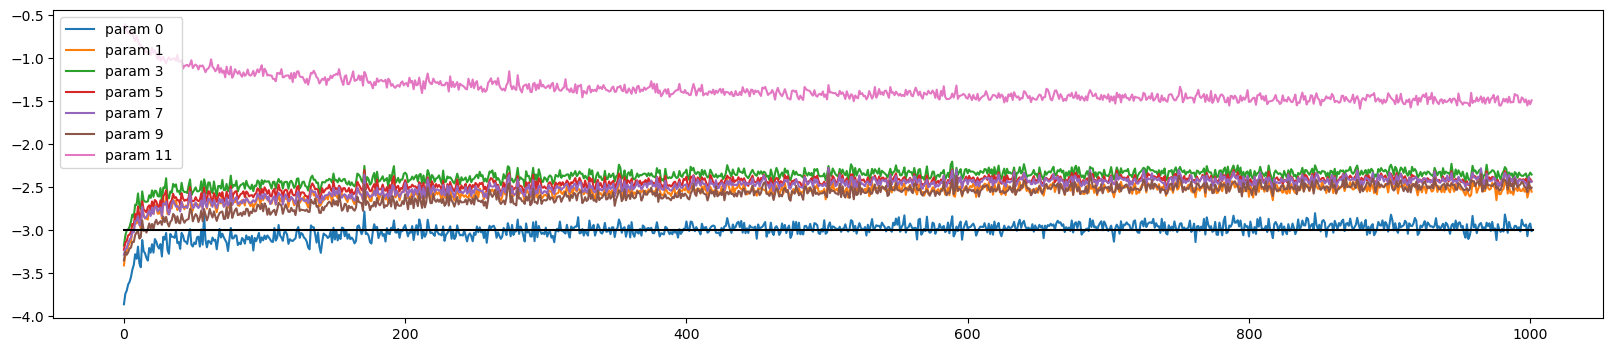

In [65]:
plt.figure(figsize = (20,4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range (len(ud))])
        legends.append('param %d ' %i)
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends);
